In [33]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import numpy as np
import cv2
import PIL as pil

In [54]:
used_dataset = 'CASIA1'

dataset_paths = {
    'CASIA1': os.path.join('D:\\', 'data_sets', 'general_image_tampering', 'CASIA', 'CASIA1'),
    'CASIA2': os.path.join('D:\\', 'data_sets', 'general_image_tampering', 'CASIA', 'CASIA2'),
    'ELA_CASIA2': os.path.join('D:\\', 'data_sets', 'general_image_tampering', 'CASIA', 'ELA_CASIA2'),
    'IMD2020': os.path.join('D:\\', 'data_sets', 'general_image_tampering', 'IMD2020'),
}

train_dir = os.path.join(dataset_paths[used_dataset], 'train')
validation_dir = os.path.join(dataset_paths[used_dataset], 'validation')

Number of authentic images: 7491
Number of tampered images: 5123


In [66]:
models = {
    'xception': tf.keras.applications.Xception,
    'inceptionv3': tf.keras.applications.InceptionV3,
    'vgg19': tf.keras.applications.VGG19,
    'vgg16': tf.keras.applications.VGG16,
    'mobilenetv2': tf.keras.applications.MobileNetV2,
    'mobilenetv3large': tf.keras.applications.MobileNetV3Large,
    'resnet101': tf.keras.applications.ResNet101
}

In [65]:
class Config:
    name = 'mobilenetv3large'
    epochs = 10
    batch_size = 32
    lr = 0.0001
    image_shape = (256, 256, 3)
    def adapt_learn_rate(epoch): return 1e-4 * 10**(epoch / 20)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        tf.keras.callbacks.LearningRateScheduler(adapt_learn_rate)
    ]

# Error Level Analysis (ELA) pre-processing

In [64]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    compressed_img = cv2.imread(temp_filename)

    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    image = pil.Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = pil.Image.open(temp_filename)

    ela_image = pil.ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = pil.ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def folder_ela_preprocess(input_folder, output_folder, quality):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        output_filename = os.path.join(output_folder, os.path.splitext(filename)[0] + '.jpg')
        if not os.path.exists(output_filename):
            print('Processing file: {}'.format(filename))
            try:
                ela_image = convert_to_ela_image(os.path.join(input_folder, filename), quality)
                ela_image.save(output_filename)
            except Exception as e:
                print(f'Error processing file: {filename}')
                print(e)
        else:
            print(f'File already exists: {filename}')


def show_ela_image(path, quality):
    image = convert_to_ela_image(path, quality)
    plt.imshow(image)


def save_ela_image(path, quality, output_path):
    image = convert_to_ela_image(path, quality)
    image.save(output_path)

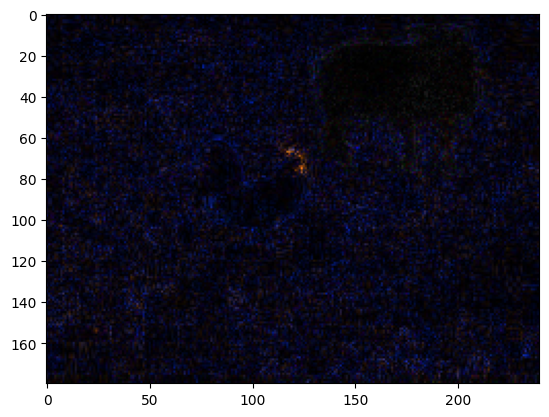

In [63]:
test_image = "D:\\data_sets\\general_image_tampering\\CASIA\\CASIA2\\tampered\\Tp_D_CRN_M_N_ani10104_ani00097_10092.tif"
show_ela_image(test_image, 90)
save_ela_image(test_image, 90, 'test.jpg')

In [53]:
# folder_ela_preprocess(os.path.join(dataset_paths['CASIA2'], 'authentic'), os.path.join(
#     dataset_paths['ELA_CASIA2'], 'authentic'), 90)

Processing file: Au_ani_00001.jpg
Processing file: Au_ani_00002.jpg
Processing file: Au_ani_00003.jpg
Processing file: Au_ani_00004.jpg
Processing file: Au_ani_00005.jpg
Processing file: Au_ani_00006.jpg
Processing file: Au_ani_00007.jpg
Processing file: Au_ani_00008.jpg
Processing file: Au_ani_00009.jpg
Processing file: Au_ani_00010.jpg
Processing file: Au_ani_00011.jpg
Processing file: Au_ani_00012.jpg
Processing file: Au_ani_00013.jpg
Processing file: Au_ani_00014.jpg
Processing file: Au_ani_00015.jpg
Processing file: Au_ani_00016.jpg
Processing file: Au_ani_00017.jpg
Processing file: Au_ani_00018.jpg
Processing file: Au_ani_00019.jpg
Processing file: Au_ani_00020.jpg
Processing file: Au_ani_00021.jpg
Processing file: Au_ani_00022.jpg
Processing file: Au_ani_00023.jpg
Processing file: Au_ani_00024.jpg
Processing file: Au_ani_00025.jpg
Processing file: Au_ani_00026.jpg
Processing file: Au_ani_00027.jpg
Processing file: Au_ani_00028.jpg
Processing file: Au_ani_00029.jpg
Processing fil

# Batch Processing

In [ ]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=Config.batch_size,
    image_size=Config.image_shape[:2],
    shuffle=True,
    seed=42
)

dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    batch_size=Config.batch_size,
    image_size=Config.image_shape[:2],
    shuffle=True,
    seed=42
)

In [ ]:
dataset_validation_cardinality = tf.data.experimental.cardinality(
    dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

# Utilizado para testar o modelo depois do término do treino do modelo
dataset_test = dataset_validation.take(dataset_validation_batches)
# Utilizado para avaliar o modelo ainda durante o treinamento
dataset_validation = dataset_validation.skip(dataset_validation_batches)

## Dataset Statistics

In [ ]:
count_train = 0
count_authentic = 0
count_tampered = 0
for image_batch, label_batch in dataset_train:
    count_train += len(image_batch)
    count_authentic += len(label_batch[label_batch == 0])
    count_tampered += len(label_batch[label_batch == 1])

print('Number of training images: ', count_train)
print('Number of training authentic images: ', count_authentic)
print('Number of training tampered images: ', count_tampered)
print('Proportion of authentic images: ', count_authentic / count_train)

count_validation = 0
count_authentic = 0
count_tampered = 0
for image_batch, label_batch in dataset_validation:
    count_validation += len(image_batch)
    count_authentic += len(label_batch[label_batch == 0])
    count_tampered += len(label_batch[label_batch == 1])

print('Number of validation images: ', count_validation)
print('Number of validation authentic images: ', count_authentic)
print('Number of validation tampered images: ', count_tampered)
print('Proportion of authentic images: ', count_authentic / count_validation)

count_test = 0
count_authentic = 0
count_tampered = 0
for image_batch, label_batch in dataset_test:
    count_test += len(image_batch)
    count_authentic += len(label_batch[label_batch == 0])
    count_tampered += len(label_batch[label_batch == 1])

print('Number of test images: ', count_test)
print('Number of test authentic images: ', count_authentic)
print('Number of test tampered images: ', count_tampered)
print('Proportion of authentic images: ', count_authentic / count_test)

# Data Augmentation

In [ ]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Feature Extraction

In [ ]:
feature_extractor = tf.keras.applications.ResNet101(
    input_shape=Config.image_shape, include_top=False, weights='imagenet')
feature_extractor.trainable = False

feature_extractor.summary()

# Model Training

In [ ]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=Config.image_shape),
        data_augmentation,
        feature_extractor,
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
tf.keras.backend.clear_session()

model = build_model()

model.compile(
    tf.keras.optimizers.Adam(learning_rate=Config.lr),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives()
    ]
)


model.summary()

In [ ]:
history = model.fit(
    dataset_train,
    validation_data=dataset_validation,
    epochs=Config.epochs,
)
history_dict = history.history

# Save Model

In [ ]:
path = os.path.join('models', f'{used_dataset}_{Config.name}_{Config.epochs}_{Config.batch_size}_{Config.lr}_{Config.image_shape[0]}')

model.save(os.path.join(path, 'model.h5'))

json.dump(history_dict, open(os.path.join(path, 'model_history.json'), 'w'))

# Load Model

In [67]:
path = os.path.join('models', 'VGG16_IMAGENET_CASIA1_20_EPOCHS')

model = tf.keras.models.load_model(os.path.join(path, 'model.h5'))

history_dict = json.load(open(os.path.join(path, 'model_history.json'), 'r'))

# Model Evaluation

## Loss Curve

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(history_dict['loss'], color='b', label="Training loss")
ax.plot(history_dict['val_loss'], color='r', label="Validation loss")
ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(loc='best', shadow=True)
ax.set_xlim(0, epochs)
ax.set_xticks(np.arange(0, epochs+1, 1))
ax.set_title('Loss')

In [ ]:
plot_metrics = [key for key in history_dict.keys() if key.split('_')[0] != 'val' and 'positives' not in key and 'negatives' not in key and key != 'loss']
plot_size = len(plot_metrics)

if plot_size > 0:
    fig, ax = plt.subplots(plot_size,1,figsize=(8,3*plot_size), constrained_layout=True, sharey=True)
    for i, metric in enumerate(plot_metrics):
        ax[i].plot(history_dict[metric], color='b', label='Training ' + metric.replace('_', ' '))
        ax[i].plot(history_dict['val_'+metric], color='r', label='Validation ' + metric.replace('_', ' '))
        ax[i].set_xlabel('Epochs',fontsize=16)
        ax[i].set_ylabel(metric.replace('_', ' ').capitalize(),fontsize=16)
        ax[i].set_ylim(0,1)
        ax[i].set_yticks(np.arange(0, 1.1, 0.1))
        ax[i].set_xlim(0,epochs)
        ax[i].set_xticks(np.arange(0, epochs+1, 1))
        legend = ax[i].legend(loc='best', shadow=True)

    fig.suptitle('Metrics',fontsize=20)

In [ ]:
plot_metrics = [key for key in history_dict.keys() if key.split(
    '_')[0] != 'val' and ('positives' in key or 'negatives' in key)]
plot_size = len(plot_metrics)
if plot_size > 0:
    fig, ax = plt.subplots(plot_size, 1, figsize=(
        8, 4*plot_size), constrained_layout=True, sharey=True)
    for i, metric in enumerate(plot_metrics):
        ax[i].plot([value/count_train for value in history_dict[metric]],
                   color='b', label='Training ' + metric.replace('_', ' '))
        ax[i].plot([value/count_validation for value in history_dict['val_'+metric]],
                   color='r', label='Validation ' + metric.replace('_', ' '))
        ax[i].set_xlabel('Epochs', fontsize=16)
        ax[i].set_ylabel(metric.replace('_', ' ').capitalize(), fontsize=16)
        ax[i].set_ylim(0, 1)
        ax[i].set_yticks(np.arange(0, 1.1, 0.1))
        ax[i].set_xlim(0, epochs)
        ax[i].set_xticks(np.arange(0, epochs+1, 1))
        legend = ax[i].legend(loc='best', shadow=True)

In [ ]:
test_results = model.evaluate(dataset_test)

for name, value in zip(model.metrics_names, test_results):
    print(name, ': ', value)